# Lotsch BETSI

Adapted from the work of **J.W.M. Osterrieth**, **D. Fairen-Jimenez** and others: 
*How reproducible are surface areas calculated from the BET equation?*

Written by **A.M. Pütz**, October 2020, MPI FKF, Stuttgart

### Requirements

Please install [Python 3](https://www.python.org/) ([Anaconda](https://www.anaconda.com/products/individual) recommended) and [JupyterLab](https://jupyter.org/install). Satisfy all dependencies (see below). 
Run this notebook from a folder containing `./Data/` and `./Output/` subfolders. 

## User variables

Below, please define the following: filename (must contain analyte, `N2` or `Ar`), if you wish to receive only results containing the isotherm knee, the minimum number of points and *R*<sup>2</sup> value required for valid BET fits, as well as the maximum relative error between experimental and calculated partial pressures at monolayer loading ([4th Rouquerol criterium](https://www.sciencedirect.com/science/article/abs/pii/S0167299107800085)).

In [11]:
filename = "standardSyn_N2.csv"
directory = ".\Data\\"

just_knee_sets = False #if True only knee sets will be considered, if False, all sets
BET_monotonicity = False #check for monotonicity of BET plot and perhaps redefine knee
label_knee = True
min_set_length = 10 #(= 10) minimum number of points considered for a BET fit
min_r2 = 0.99 #(= 0.995) minimum quality of BET fit as described by R2
max_pp_error = 20 #(= 20 %) maximum error between partial pressures of monolayer loading, 4th Rouquerol criterium

### Calculations

*↓ scroll down for results ↓*

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import seaborn as sns
import numpy as np
import pandas as pd
import pylab
import statsmodels.formula.api as sm
pd.options.mode.chained_assignment = None #supress df loc warnings

#import and process raw data
if 'N2' in filename: #extract cross sectional area (nm2) depending on gas
    cross_section = 0.162
elif 'Ar' in filename:
    cross_section = 0.142
    
data_full = pd.read_csv(directory+filename, names=["relpress","quantity"], skiprows=1, engine='python') #import isotherm into pandas dataframe
data = data_full.truncate(after=data_full["quantity"].idxmax()) #truncate analysis data to adsorption only
data_full['type'] = 'Adsorption' #label data points
data_full['type'].loc[data_full["quantity"].idxmax()+1:] = 'Desorption'

data["amountmol"] = data["quantity"]/22.4 #recalculate quantity (cm3 g-1) to amount (mmol g-1)
data["rouquerol"] = data["amountmol"]*(1-data["relpress"]) #calculate Rouquerol plot n(1-p/p0) (mmol g-1)
data["betplot"] = data["relpress"]/(data["amountmol"]/1000)/(1-data["relpress"]) #calculate BET plot (p/p0)/[n(1-p/p0)] (g mol-1)

upper_limit = data["rouquerol"].idxmax() #in case idmax value is still monotonically increasing
for i in range(0, data["rouquerol"].idxmax()+1): #iterate through rouquerol plot and find knee, i.e., value up to which it increases monotonically with p/p0
    if data["rouquerol"][i]-data["rouquerol"][i+1] < 0: #continue search if next value is higher
        pass 
    else: #stop search and save current value as knee if next value is smaller
        upper_limit = i+1                                                   #added plus one as it always seemed one short 
        break

print("Knee ID = "+str(upper_limit))

Knee ID = 34


In [13]:
#calculate OLS regression for each combination of >=10 points of BET and saves results

intercept = np.zeros([upper_limit+1, upper_limit+1])
slope = np.zeros([upper_limit+1, upper_limit+1])
error = np.zeros([upper_limit+1, upper_limit+1])
c = np.zeros([upper_limit+1, upper_limit+1]) #C constant, 1st Rouquerol criterium
nm_bet = np.zeros([upper_limit+1, upper_limit+1]) #monolayer amount according to BET plot (mmol g-1)
pp_bet = np.zeros([upper_limit+1, upper_limit+1]) #partial pressure at nm(BET)
pp_exp = np.zeros([upper_limit+1, upper_limit+1])
pp_error = np.ones([upper_limit+1, upper_limit+1])
area = np.zeros([upper_limit+1, upper_limit+1]) #BET area (m2 g-1)\n",

for i in range(0, upper_limit+1):
    for j in range(0, upper_limit+1):
        
        bet_increasing = True
        if BET_monotonicity:
            #perform a first monotonicity check on each BET and discard those that are not
            for n in range(i, j): #iterate through BET plot and check; end should be j, but knee group should always be included
                if data["betplot"][n]-data["betplot"][n+1] < 0: #continue search if next value is higher
                    pass 
                else: #stop search and reject BET if next value is smaller
                    bet_increasing = False
                    print("BET plot "+str(i)+".."+str(j)+" rejected!")
                    break
        
        if j-i > min_set_length-1 and bet_increasing: #only fit sets of at least 10 points and that increase monotonically
            result = sm.ols(formula="betplot ~ relpress", data=data.iloc[i:j+1]).fit()
            intercept[i][j] = result.params.Intercept
            error[i][j] = result.rsquared
            slope[i][j] = result.params.relpress
            
            c[i][j] = 1+slope[i][j]/intercept[i][j]
            nm_bet[i][j] = 1/(slope[i][j] + intercept[i][j])*1000
            
            if c[i][j] > 0: #apply check for negative C constant, then proceed or write 0 to array
                pp_bet[i][j] = 1/(np.sqrt(c[i][j])+1) #calculate partial pressure corresponding to n_m(BET) as derived by BET 
                from scipy.interpolate import interp1d
                df_interp = interp1d(data['amountmol'], data['relpress'], kind='quadratic') #create interpolation function for data
                try: 
                    pp_exp[i][j] = df_interp(nm_bet[i][j]) #get partial pressure of interpolated data for y = n_m(BET) = n_m(exp)
                    pp_error[i][j] = abs((pp_bet[i][j]-pp_exp[i][j]))/pp_bet[i][j] #calculate relative error
                
                    #check if n_m(exp) is within BET plot and that p/p0(exp) does not deviate from p/p0(BET) by more than 20 %, 
                    #then calculate BET area from BET equation based on linear BET fit
                    if pp_error[i][j] <= max_pp_error/100 and error[i][j] >= min_r2 and data['relpress'][i] <= pp_exp[i][j] <= data['relpress'][j]: 
                        area[i][j] = nm_bet[i][j]/1000*602214*cross_section  
                    else: #if any conditions are failed, set arrays back to standard (arbitrary) value
                        pp_error[i][j] = 1
                except:
                    print("Exeption thrown.")
                    area[i][j] = 0
                    pp_error[i][j] = 1

pd.set_option("display.max_rows", None, "display.max_columns", None)
np.set_printoptions(threshold=np.inf)
#print(area)
#print(pp_error)
print(area[np.where(pp_error == pp_error.min())[0][0]][np.where(pp_error == pp_error.min())[1][0]])
#print(pp_error[:,upper_limit].argmin())
print(upper_limit)

1472.0841245784554
34


In [14]:
#prepare smoothed BET data
def smooth(x,window_len=3,window='hanning'):
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    w = eval('np.'+window+'(window_len)')
    x_smooth = np.convolve(w/w.sum(),s,mode='valid')
    return x_smooth
betplot_smooth = smooth(data["betplot"])

lower_limit = 0

#perform a second monotonicity check close to the best BET range and redefine knee
if BET_monotonicity:
    for n in range(np.where(pp_error == pp_error.min())[0][0]+2, upper_limit+1): #current best range up to and including rouquerol knee
    #    if betplot_smooth[n]-betplot_smooth[n+1] < 0: #continue search if next value is higher
        if data['betplot'][n]-data['betplot'][n+1] < 0: #continue search if next value is higher
            pass 
        else: #stop search and reassign knee if next value is smaller
            upper_limit = n
            #print("New upper limit; BET plot increases monotonically up to "+str(n)+"!")
            break
    #with final upper limit, ckeck decreasing monotonicity of BET
    lower_limit = 0
    for n in reversed(range(0, upper_limit)): #reverse search from knee to bottom
    #    if betplot_smooth[n]-betplot_smooth[n+1] > 0: #continue search if next value is higher
        if data['betplot'][n]-data['betplot'][n+1] < 0: #continue search if next value is higher
            pass 
        else: #stop search and reassign knee if next value is bigger
            lower_limit = n
            #print("New lower limit; BET plot decreases monotonically down to "+str(n)+"!")
            break
    print("Final limits are "+str(lower_limit)+".."+str(upper_limit))            
            
#find BET area with lowest error and extract indices, formated as [[i],[j]]
if just_knee_sets: idx_best_area = [[pp_error[lower_limit:,upper_limit].argmin()],[upper_limit]] #search best result between new limits
else: idx_best_area = np.where(pp_error == pp_error.min()) #search best result in entire range (should never turn out to include kink in BET)
best_area = area[idx_best_area[0][0]][idx_best_area[1][0]] #uses index to call best area from array

#save labelled data
if just_knee_sets: savename = ".\Output\\"+filename[:-4]+"_knee"
else: savename = ".\Output\\"+filename[:-4]
data.to_csv(savename+".csv",index=False)

#reduce to valid data set and prepare for error plot
valid_fits = np.where(pp_error != 1)
area_list, error_list, i_list, j_list = [],[],[],[]
for i in range(0,len(valid_fits[0])):
    area_list.append(area[valid_fits[0][i]][valid_fits[1][i]])
    error_list.append(pp_error[valid_fits[0][i]][valid_fits[1][i]])
    i_list.append(valid_fits[0][i])
    j_list.append(valid_fits[1][i])
    
error_list_percent = [i * 100 for i in error_list] #convert error values to % 
error_plot = pd.DataFrame(area_list, columns =['area'])
error_plot['error'] = error_list
error_plot['error_percent'] = error_list_percent
error_plot['i'] = i_list
error_plot['j'] = j_list

#assign type labels for export and plotting
data['type'] = 'Absorption isotherm'
data['type'].iloc[idx_best_area[0][0]:idx_best_area[1][0]] = 'Linear BET range'
if label_knee: data['type'].iloc[upper_limit] = 'Knee'
error_plot['type'] = 'All results'
if label_knee: error_plot['type'].loc[error_plot['j'] == upper_limit] = 'Knee set'
error_plot['type'].loc[error_plot['error'] == pp_error[idx_best_area[0][0]][idx_best_area[1][0]]] = 'Best result'

#pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(idx_best_area)
#print(data)

In [15]:
def create_report(): #create report 
    if just_knee_sets and best_area == 0: #warn user about lack of valid results when knee is enabled and end here
        print("No valid result found in knee set. Try again without this option.") #warn user about lack of valid results when knee is enabled and end here
        return
    
    if best_area == 0: #warn user about lack of valid results and offer alternatives
        print("No valid result found. Try relaxing R2, or maximum error between BET-derived and experimental p/p0 at monolayer loading. (Warning: 4th Rouquerol criterium!)") 
        return
    
    summary = 50*'='
    summary += '\n'+14*' '+'Lotsch BETSI - Summary'+14*' '
    summary += '\n'+50*'='
    #summary += '\n'+'Fit parameters:'
    summary += '\n'+'  Fitting set    '+str(idx_best_area[0][0])+'..'+str(idx_best_area[1][0])
    summary += '\n'+'  Fitting range  '+str(data['relpress'][idx_best_area[0][0]])+'...'+str(data['relpress'][idx_best_area[1][0]])
    summary += '\n'+'  Slope          '+"{:.2f}".format(slope[idx_best_area[0][0]][idx_best_area[1][0]])+' g mmol-1'
    summary += '\n'+'  Intercept      '+"{:.2f}".format(intercept[idx_best_area[0][0]][idx_best_area[1][0]])+' g mmol-1'
    summary += '\n'+'  R2             '+"{:.6f}".format(error[idx_best_area[0][0]][idx_best_area[1][0]])+'\n'
    
    #summary += '\n'+'Results:'
    summary += '\n'+'  as(BET)    '+"{:.2f}".format(best_area)+' m2g-1'
    summary += '\n'+'  C          '+"{:.2f}".format(c[idx_best_area[0][0]][idx_best_area[1][0]])
    summary += '\n'+'  nm(BET)    '+"{:.2f}".format(nm_bet[idx_best_area[0][0]][idx_best_area[1][0]])+' mmol g-1'
    summary += '\n'+'  p/p0(BET)  '+"{:.6f}".format(pp_bet[idx_best_area[0][0]][idx_best_area[1][0]])
    summary += '\n'+'  p/p0(exp)  '+"{:.6f}".format(pp_exp[idx_best_area[0][0]][idx_best_area[1][0]])
    summary += '\n'+'  Rel. error '+"{:.2f} %".format(100*pp_error[idx_best_area[0][0]][idx_best_area[1][0]])
    
    # save results to TXT file and print
    with open(savename+".txt","w") as file: file.write(summary)
    print(summary)
    
def create_figure(): #create all plots
    colors = ['#5C6F92','#E98F4C','#91354B','#CFCFCF','#12316A','#8EA5B8','#C8697F']
    pal = sns.color_palette(palette=colors, n_colors=len(colors))
    sns.set_theme(style="ticks", font_scale=0.25)
    sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
    sns.set_palette(pal)
    linewidth = 0.6
    ticklength = 3
    fontsize = 6
    
    def set_figure(fig):
        fig.tick_params('both', length=ticklength, width=linewidth, which='major')
        fig.tick_params('both', length=ticklength/2, width=linewidth, which='minor')
        fig.spines['top'].set_linewidth(linewidth)
        fig.spines['right'].set_linewidth(linewidth)
        fig.spines['bottom'].set_linewidth(linewidth)
        fig.spines['left'].set_linewidth(linewidth)
        lgnd = plt.legend(title=None, fontsize=fontsize, frameon=False)
        for lh in lgnd.legendHandles: 
            lh._sizes = [linewidth*10]
            lh.set_alpha(1)

    plt.figure(figsize=(6.90,6.74), dpi= 300).subplots_adjust(hspace=0.4, wspace=0.3)
    plt.subplot(3, 3, 1)
    g1 = sns.scatterplot(
        data=data_full, x='relpress', y='quantity', 
        alpha=0.5,
        hue='type',
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"Equilibrium relative pressure $p/p^{0}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"Volume ads. at STP / cm$^{3}$ g$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.title('Isotherm', fontsize=fontsize, style='italic', pad = 2)
    #plt.xscale('log')
    set_figure(g1)
    g1.set_xticklabels(g1.get_xticks(), size = fontsize)
    g1.set_yticklabels(g1.get_yticks(), size = fontsize)
    g1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    g1.xaxis.set_major_formatter(ticker.ScalarFormatter())
    
    
    plt.subplot(3, 3, 2)
    g2 = sns.scatterplot(
        data=data, x='relpress', y='rouquerol', 
        alpha=0.5,
        hue='type',
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"Equilibrium relative pressure $p/p^{0}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"$n^{a}(1-p/p^{0})$ / mmol g$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.title('Rouquerol representation', fontsize=fontsize, style='italic', pad = 2)
    set_figure(g2)
    g2.set_xticklabels(g2.get_xticks(), size = fontsize)
    g2.set_yticklabels(g2.get_yticks(), size = fontsize)
    g2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    g2.xaxis.set_major_formatter(ticker.ScalarFormatter())


    plt.subplot(3, 3, 3)
    g3 = sns.scatterplot(
        data=data.iloc[0:upper_limit+1], x='relpress', y='betplot', 
        alpha=0.5,
        hue='type',
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"Equilibrium relative pressure $p/p^{0}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"$(p/p^{0})/[n^{a}(1-p/p^{0})]$ / g mol$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.title('BET plot under 1$^{\mathrm{st}}$ Rouquerol crit.', fontsize=fontsize, style='italic', pad = 2)
    set_figure(g3)
    g3.set_xticklabels(g3.get_xticks(), size = fontsize)
    g3.set_yticklabels(g3.get_yticks(), size = fontsize)
    g3.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    g3.xaxis.set_major_formatter(ticker.ScalarFormatter())

    #append nm(read) and nm(BET) to data for plotting
    nm_data = {'relpress': [pp_bet[idx_best_area[0][0]][idx_best_area[1][0]], pp_exp[idx_best_area[0][0]][idx_best_area[1][0]]], 
               'quanity': [nm_bet[idx_best_area[0][0]][idx_best_area[1][0]]*22.4, nm_bet[idx_best_area[0][0]][idx_best_area[1][0]]*22.4],
               'amountmol' : [nm_bet[idx_best_area[0][0]][idx_best_area[1][0]], nm_bet[idx_best_area[0][0]][idx_best_area[1][0]]],
               'rouquerol' : [np.NaN,np.NaN],
               'betplot' : [np.NaN,np.NaN],
               'type' :['nm(BET)','nm(exp)']
              }
    data_appended = pd.concat([data, pd.DataFrame(data = nm_data)])

    plt.subplot(3, 3, 4)
    g4 = sns.scatterplot(
        data=data_appended, x='relpress', y='amountmol', 
        hue='type',
        alpha=0.5,
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"Equilibrium relative pressure $p/p^{0}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"Amount adsorbed $n^{a}}$ / mmol g$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.title('Linear ads. isotherm', fontsize=fontsize, style='italic', pad = 2)
    set_figure(g4)
    g4.set_xticklabels(g4.get_xticks(), size = fontsize)
    g4.set_yticklabels(g4.get_yticks(), size = fontsize)
    g4.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    g4.xaxis.set_major_formatter(ticker.ScalarFormatter())

    plt.subplot(3, 3, 5)
    g5 = sns.scatterplot(
        data=data_appended, x='relpress', y='amountmol', 
        hue='type',
        alpha=0.5,
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"Equilibrium relative pressure $p/p^{0}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"Amount adsorbed $n^{a}}$ / mmol g$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.title('Semi-logarithmic ads. isotherm', fontsize=fontsize, style='italic', pad = 2)
    plt.xscale('log')
    set_figure(g5)
    g5.set_xticklabels(g5.get_xticks(), size = fontsize)
    g5.set_yticklabels(g5.get_yticks(), size = fontsize)

    plt.subplot(3, 3, 6)
    g6 = sns.scatterplot(
        data=data.iloc[idx_best_area[0][0]:idx_best_area[1][0]], x='relpress', y='betplot', 
        alpha=0.5,
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"Equilibrium relative pressure $p/p^{0}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"$(p/p^{0})/[n^{a}(1-p/p^{0})]$ / g mol$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.title('Linear range of BET plot', fontsize=fontsize, style='italic', pad = 2)
    set_figure(g6)
    #plots the BET plot
    fit_x = data['relpress'].iloc[idx_best_area[0][0]:idx_best_area[1][0]]
    fit_y = slope[idx_best_area[0][0]][idx_best_area[1][0]]*fit_x+intercept[idx_best_area[0][0]][idx_best_area[1][0]]
    plt.plot(fit_x, fit_y, color='b',linewidth=linewidth)
    #adds info into legend
    lgnd = plt.legend(title=None, loc='upper left', labels=['Linear fit', 'BET plot'], fontsize=fontsize, frameon=False)
    for lh in lgnd.legendHandles: 
        lh._sizes = [linewidth*10]
        lh.set_alpha(1)
    g6.set_xticklabels(g6.get_xticks(), size = fontsize)
    g6.set_yticklabels(g6.get_yticks(), size = fontsize)
    g6.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
    g6.xaxis.set_major_formatter(ticker.ScalarFormatter())

    plt.subplot(3, 3, (7,9))
    g7 = sns.scatterplot(
        data=error_plot, x='area', y='error_percent', 
        alpha=0.5,
        hue='type',
        edgecolor=None,
        linewidth=linewidth*0.67,
        s=linewidth*15
    )
    plt.xlabel(r"BET area $a_{s}$(BET) / m$^{2}$ g$^{-1}$", fontsize=fontsize, labelpad = 2)
    plt.ylabel(r"Relative Error / %", fontsize=fontsize, labelpad = 2)
    plt.title("Valid results represented as relative error between $p/p^{0}$ of $n_{m}$(BET) and $n_{m}$(exp) vs. BET area", fontsize=fontsize, style='italic', pad = 2)
    set_figure(g7)
    for line in range(0,error_plot.shape[0]):
         g7.text(error_plot.area[line]+0.01, error_plot.error_percent[line], 
         str(error_plot.i[line])+','+str(error_plot.j[line]), horizontalalignment='left', 
         size='x-small', color='black', weight='normal', fontsize=fontsize)    
    g7.set_xticklabels(g7.get_xticks(), size = fontsize)
    g7.set_yticklabels(g7.get_yticks(), size = fontsize)
    
    plt.subplots_adjust(wspace=0.5)

    #saves figure
    print(savename)
    plt.savefig(savename+".pdf")
    plt.savefig(savename+".svg")

## Results

Please find the report and overview figure below. These (in TXT and PDF format) and a CSV containing all data for addition plotting were saved in `./Output/`.

In [16]:
create_report()

              Lotsch BETSI - Summary              
  Fitting set    16..26
  Fitting range  0.00101761...0.07406
  Slope          65.99 g mmol-1
  Intercept      0.29 g mmol-1
  R2             0.994093

  as(BET)    1472.08 m2g-1
  C          231.95
  nm(BET)    15.09 mmol g-1
  p/p0(BET)  0.061615
  p/p0(exp)  0.061400
  Rel. error 0.35 %


<ipython-input-15-3437a620fb9f>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(g1.get_xticks(), size = fontsize)
<ipython-input-15-3437a620fb9f>:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_yticklabels(g1.get_yticks(), size = fontsize)
<ipython-input-15-3437a620fb9f>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  g2.set_xticklabels(g2.get_xticks(), size = fontsize)
<ipython-input-15-3437a620fb9f>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  g2.set_yticklabels(g2.get_yticks(), size = fontsize)
<ipython-input-15-3437a620fb9f>:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  g3.set_xticklabels(g3.get_xticks(), size = fontsize)
<ipython-input-15-3437a620fb9f>:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  g3.set_yticklabels(g3.get_yticks(), size = fontsize)
<i

.\Output\standardSyn_N2


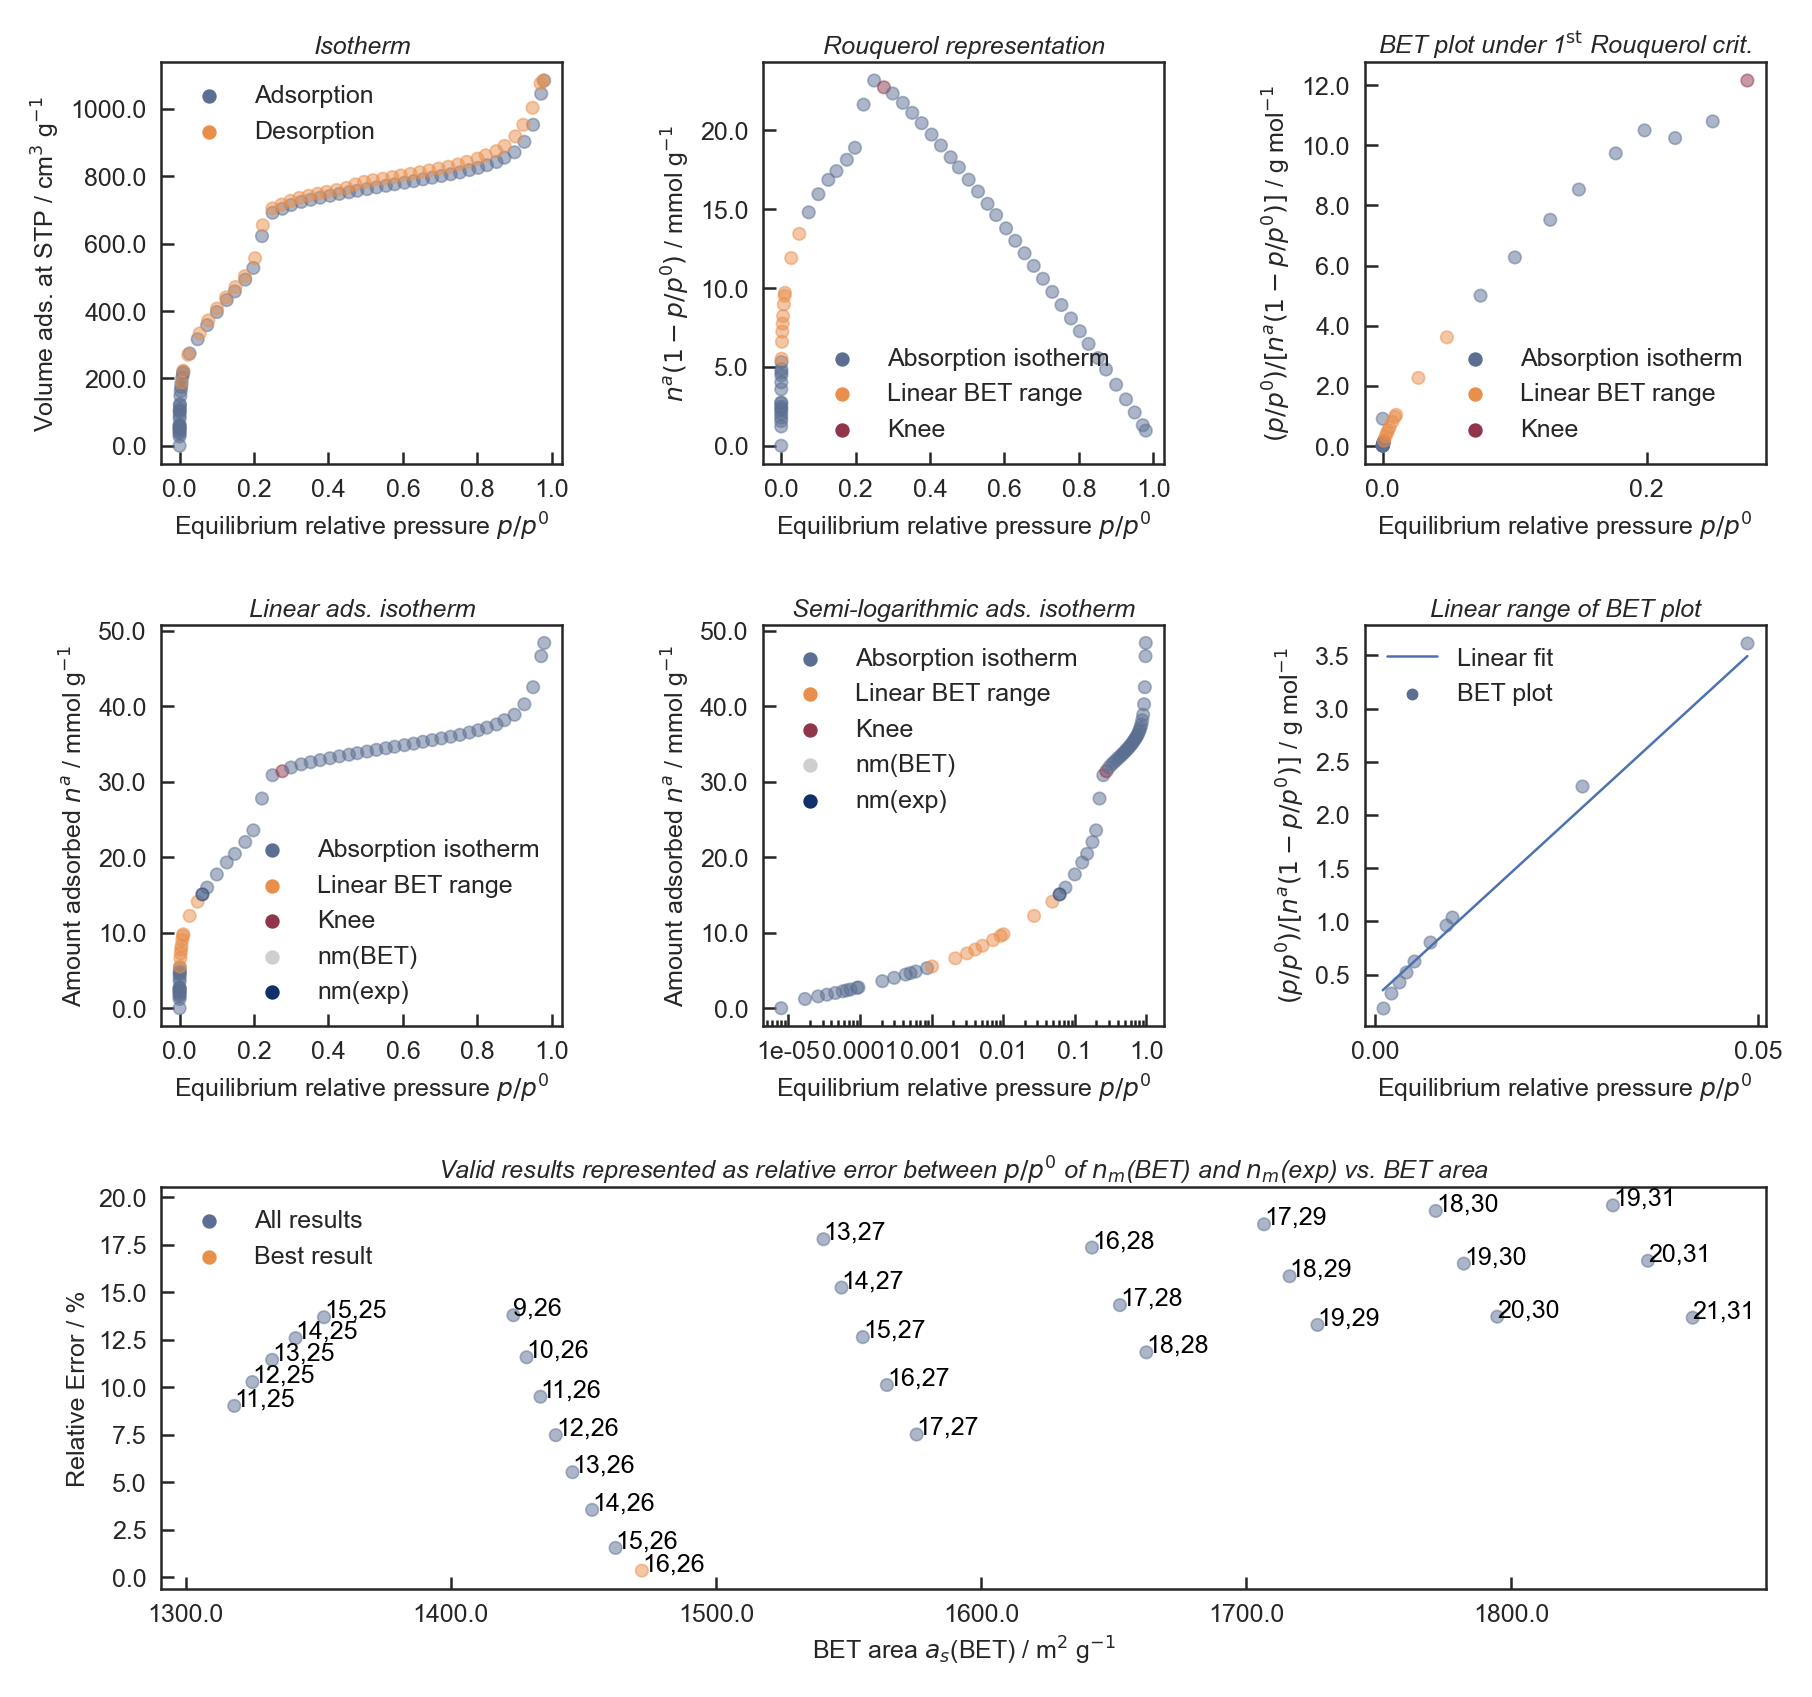

In [17]:
create_figure()